# Trainable segmentation using local features and random forests

Pixel based segmentation using local features at different scales:
- local intensity
- edges
- textures

Pixels of user-provided mask used to identify different regions and train a random forest classifier from sci-kit learn. Unlabelled pixels are then labeled from prediction of the classifier. 

- Adding in napari for annotations
- dask lazy load

Libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import napari
import tifffile
from dask import delayed
from dask_image.imread import imread
from dask import array as da 

Load skin data from scikit and convert to tif 

In [43]:
# Load data
skin = data.skin()
sub_skin = skin[:900, :900]

Load 3D cell dataset from skimage

In [57]:
from skimage.data import cells3d
image = cells3d()
image.shape

(60, 2, 256, 256)

Create Training Labels: 
- Creating a ground truth segmentation mask (training_labels) by user specifying regions of interest in the image.

In [118]:
# Open Napari viewer
viewer = napari.Viewer()

# Display the image and labels in the same window
viewer.add_image(sub_skin, name='Skin Image')
training_labels = viewer.add_labels(np.zeros(sub_skin.shape[:2]).astype(int))

# Run the Napari viewer
napari.run()

In [119]:
annotations = training_labels.data

In [120]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(sub_skin)
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(annotations, features, clf)
result = future.predict_segmenter(features, clf)

In [121]:
# Open Napari viewer
viewer = napari.Viewer()

# Display the image and labels in the same window
viewer.add_image(sub_skin, name='Skin Image')
viewer.add_image(result, name='result Image')
# Run the Napari viewer
napari.run()

### Feature importance

- Inspect the importance of different features computed by sci-kit learn
- Intensity features have a higher importance here than texture
- If reduce the number of features based on this, can lead to overfitting and degraded result within the boundary of regions

In [122]:
l = len(clf.feature_importances_)
l

45

In [123]:
feature_importance = (
        clf.feature_importances_[:l//3],
        clf.feature_importances_[l//3:2*l//3],
        clf.feature_importances_[2*l//3:])

In [124]:
sigmas = np.logspace(
        np.log2(sigma_min), np.log2(sigma_max),
        num=int(np.log2(sigma_max) - np.log2(sigma_min) + 1),
        base=2, endpoint=True)

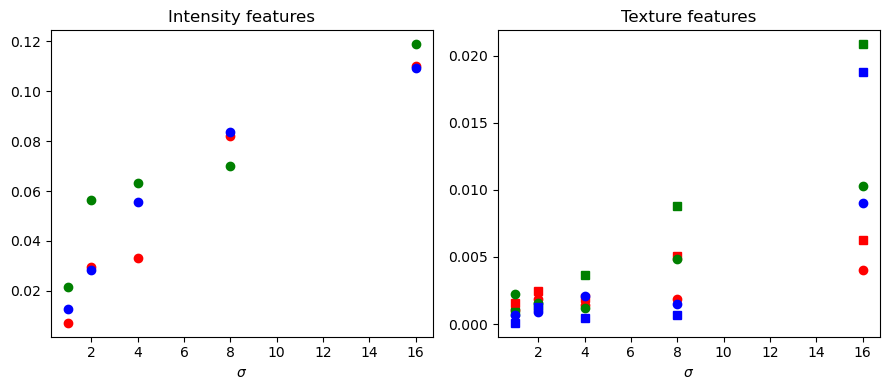

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4)) # change numb subplots depending of features

for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[0].plot(sigmas, feature_importance[ch][::3], 'o', color=color)
    ax[0].set_title("Intensity features")
    ax[0].set_xlabel("$\\sigma$")
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[1].plot(sigmas, feature_importance[ch][1::3], 'o', color=color)
    ax[1].plot(sigmas, feature_importance[ch][2::3], 's', color=color)
    ax[1].set_title("Texture features")
    ax[1].set_xlabel("$\\sigma$")

fig.tight_layout()

- the x-axis represents the scale parameter $\sigma$, and the y-axis represents the importance of the feature.



### Fitting new images

In [127]:
# Generate new img
img_new = skin[:700, 900:]

In [128]:
features_new = features_func(img_new)
result_new = future.predict_segmenter(features_new, clf)

In [129]:
# Open Napari viewer
viewer = napari.Viewer()

# Display the image and labels in the same window
viewer.add_image(img_new, name='Skin Image')
viewer.add_image(result_new, name='result Image')
# Run the Napari viewer
napari.run()